# Analiza współdziałania poprzez badanie synchroniczności ruchu na nagraniach wideo

### 28.10.2017

### Julian Zubek, Laboratorium Psychologii Rozwoju Małego Dziecka UJ

## Kontekst badania

Badanie podłużne rozwoju teorii umysłu/zdolności do mentalizacji u małych dzieci (pomiar od 1 do 6 roku życia, co 6 miesięcy).

Pytania:
* Na ile różne zdolności wiązane przez badaczy z konstruktem „teorii umysłu” są ze sobą spójne?
* Jakie są związki zdolności do mentalizacji ze zdolnościami komunikacyjnymi i interakcyjnymi?
* Czy wyniki klasycznych zadań, sprawdzających zdolność dziecka do reprezentowania cudzych stanów mentalnych (testy fałszywych przekonań), są powiązane z zachowaniami obserwowanymi w codziennej interakcji?

Materiał wyjściowy: nagrania dziecka i rodzica zaangażowanych w grę koordynacyjną.

<img src="labirynt.png" />

Różne funkcje ruchu:
* kontrolowanie własnej uwagi (przenoszenie wzroku z kulki na partnera, pochylenie)
* kontrolowanie uwagi partnera (gestykulowanie, zmiana pozycji ciała, wskazywanie)
* zajmowanie strategicznej pozycji (zbliżanie się i oddalanie od stolika, zmiana uchwytu sznurków)
* kontrola ruchu kulki (przyciąganie i luzowanie sznurków)

## Poklatkowa metoda różnicowa (ang. frame difference method)

Poruszający się obiekt na tle statycznego tła manifestuje się jako zmiana koloru pikseli z klatki na klatkę w pewnym obszarze. Obliczając średnią liczbę pikseli zmieniających kolor można w przybliżeniu ocenić ilość ruchu. Stosując tę metodę oddzielnie dla wybranych regionów obrazu można uzyskać miarę ruchomości poszczególnych osób na nagraniu.

<img src="pixel.png" />

## Przygotowanie danych

In [23]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import scipy.signal
from scipy.stats import ttest_ind
import numpy as np
import glob
import seaborn as sns
import os
from scipy import misc

matplotlib.rcParams['figure.figsize'] = (30.0, 10.0)

%matplotlib inline
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


Dane wejściowe są zaszumione z powodu artefaktów kamery, oświetlenia itp.

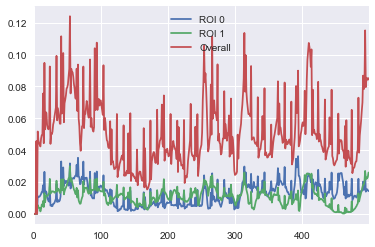

In [7]:
pd.read_csv("fd_03_78_009.csv")[:500].plot()

Bardziej znaczący obraz ruchu obiektów można otrzymać stosując filtr dolnoprzepustowy do odfiltrowania wysokich częstotliwości.

<img src="Butterworth_response.png" width="800px" />

In [99]:
def create_butterworth_filter():
    cuttoff_freq = 0.75
    ds = 25
    norm_pass = cuttoff_freq/(ds/2)
    norm_stop = 1.5*norm_pass
    (N, Wn) = scipy.signal.buttord(wp=norm_pass, ws=norm_stop, gpass=2,
                                   gstop=30, analog=0)
    (b, a) = scipy.signal.butter(N, Wn, btype='low', analog=0, output='ba')
    return lambda x: scipy.signal.lfilter(b, a, x)

butterworth_filter = create_butterworth_filter()

def filter_data(data):
    return pd.DataFrame({c: butterworth_filter(data[c].values) for c in data})

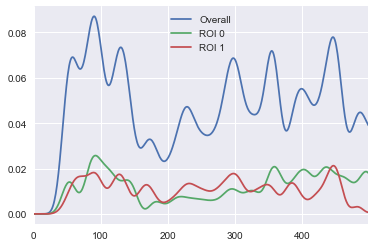

In [100]:
filter_data(pd.read_csv("fd_03_78_009.csv")[:500]).plot()

In [116]:
fd69A = pd.read_csv("fd_03_78_069_A.csv")
fd69B = pd.read_csv("fd_03_78_069_B.csv")
fd69B.columns = ["ROI 1", "ROI 0", "Overall"]
fd69 = pd.concat((fd69A, fd69B))
fd69.to_csv("fd_03_78_069.csv")

## Analizy korelacji wzajemnej

Korelacja wzajemna to współczynnik korelacji Pearsona dwóch szeregów czasowych przesuniętych względem siebie o $\Delta t$ pozycji. Analizuję korelację w oknie czasowym 8 sekund (maksymalne przesunięcie szeregów 4 sekundy w jedną stronę).

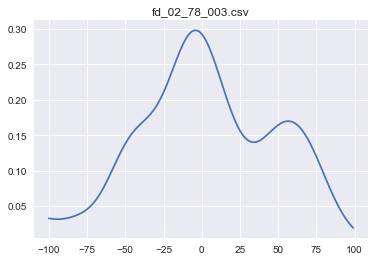

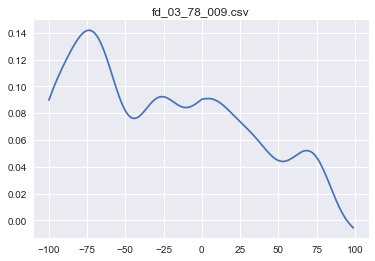

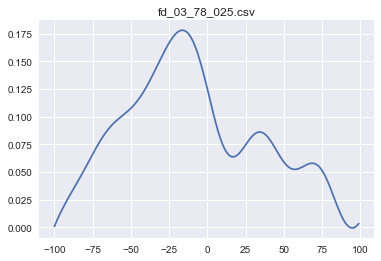

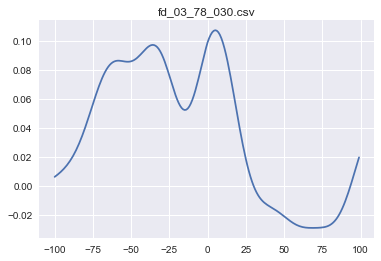

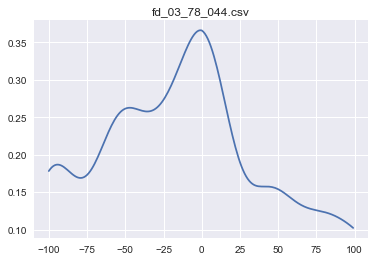

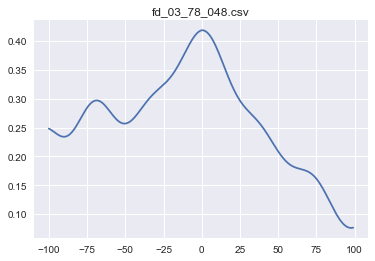

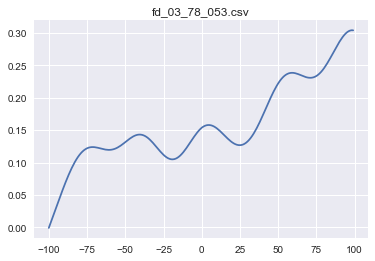

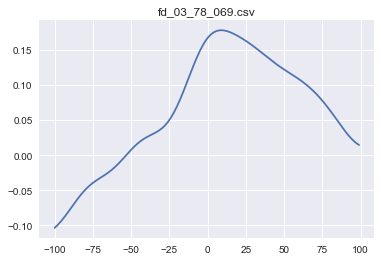

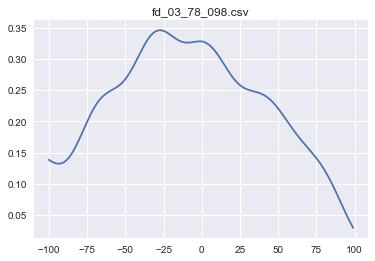

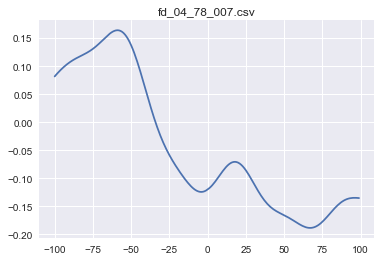

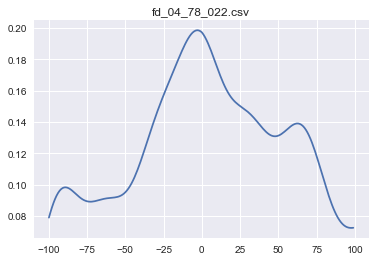

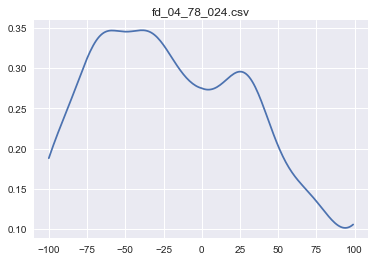

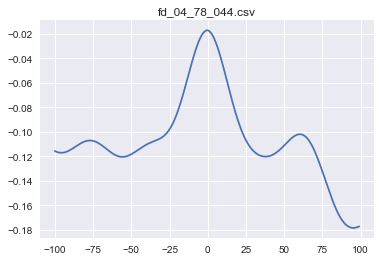

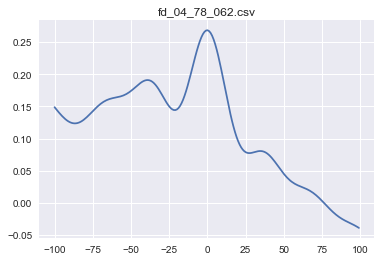

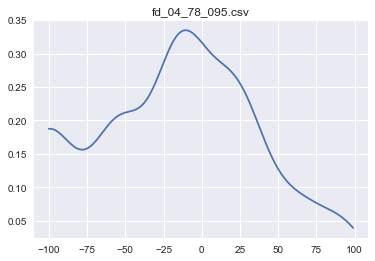

In [101]:
filenames = sorted([f for f in glob.glob("fd*.csv") if not (f[-5] == "A" or f[-5] == "B")])
corr0 = []
corr_max = []
corr_shift = []
corr_lr = []
window = range(-100, 100)

df_list = {}

for file in filenames:
    data = filter_data(pd.read_csv(file))
    df_list[file] = data
    cross_corr = np.array([data["ROI 0"].corr(data["ROI 1"].shift(d)) for d in window])
    corr0.append(cross_corr[100])
    corr_max.append(cross_corr.max())
    corr_shift.append(np.argmax(cross_corr))
    corr_lr.append(np.abs(cross_corr[:100]).mean()/np.abs(cross_corr[101:]).mean())
    plt.plot(window, cross_corr)
    plt.title(file)
    plt.show()

Wyróżniam trzy sumaryczne miary korelacji:
* corr0 -- korelacja bez przesunięcia
* corr_max -- maksymalna korelacja w oknie czasowym
* corr_lr -- stosunek średniej korelacji przy przesunięciu w przód i w tył

Pierwsze dwa współczynniki obrazują ogólną synchronizację dziecka i rodzica. Trzeci współczynnik oznacza podążanie dziecka za rodzicem (wartości > 1) lub podążanie rodzica za dzieckiem (wartości < 1).

In [63]:
stats = pd.read_csv("stats.csv", index_col=0)
stats["corr0"] = corr0
stats["corr_max"] = corr_max
stats["corr_shift"] = corr_shift
stats["corr_lr"] = corr_lr

## Synchronizacja ruchu a teoria umysłu

Na podstawie wyników testów fałszywych przekonań we wcześniejszych etapach wyróżniliśmy dwie grupy dzieci o odpowiednio wysokim i niskim poziomie zdolności do mentalizacji. W analizach porównałem poziom poszczególnych miar synchronizacji w obu grupach.

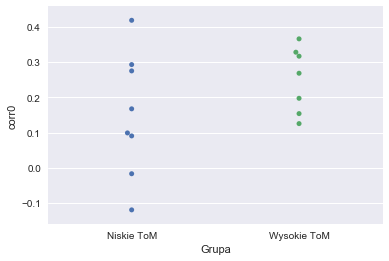

In [64]:
sns.swarmplot(y="corr0", x="Grupa", data=stats)

In [65]:
ttest_ind(stats["corr0"][stats["Grupa"] == "Niskie ToM"], stats["corr0"][stats["Grupa"] == "Wysokie ToM"])

Ttest_indResult(statistic=-1.347056420224982, pvalue=0.20097489279577316)

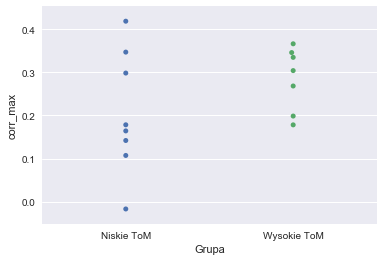

In [66]:
sns.swarmplot(y="corr_max", x="Grupa", data=stats)

In [67]:
ttest_ind(stats["corr_max"][stats["Grupa"] == "Niskie ToM"], stats["corr_max"][stats["Grupa"] == "Wysokie ToM"])

Ttest_indResult(statistic=-1.349227487156849, pvalue=0.20029498291662101)

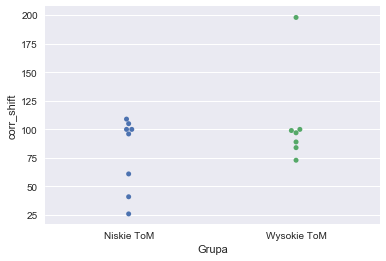

In [68]:
sns.swarmplot(y="corr_shift", x="Grupa", data=stats)

In [69]:
ttest_ind(stats["corr_shift"][stats["Grupa"] == "Niskie ToM"], stats["corr_shift"][stats["Grupa"] == "Wysokie ToM"])

Ttest_indResult(statistic=-1.3553553008672292, pvalue=0.19838606984508741)

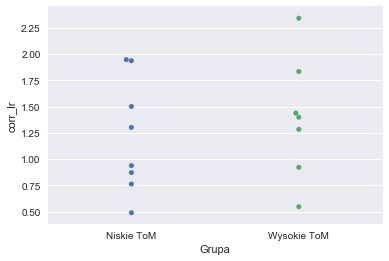

In [70]:
sns.swarmplot(y="corr_lr", x="Grupa", data=stats)

In [71]:
ttest_ind(stats["corr_lr"][stats["Grupa"] == "Niskie ToM"], stats["corr_lr"][stats["Grupa"] == "Wysokie ToM"])

Ttest_indResult(statistic=-0.60560617783307891, pvalue=0.55520247459075578)

## Synchronizacja ruchu a inicjowanie uwagi

Na samym początku projektu dzieci w wieku 12 miesięcy były badane przy użyciu narzędzia obserwacyjnego ESCS (Early Social Communication Scale), w ramach którego zliczano reakcje dziecka nakierowane na inicjowanie wspólnej uwagi z dorosłym. Na ile zdolności komunikacyjne przejawiane w wieku 12 miesięcy pozostają widoczne w interakcji w wieku 6 lat? 

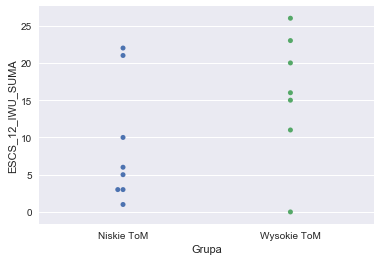

In [91]:
sns.swarmplot(y="ESCS_12_IWU_SUMA", x="Grupa", data=stats)

In [92]:
ttest_ind(stats["ESCS_12_IWU_SUMA"][stats["Grupa"] == "Niskie ToM"], stats["ESCS_12_IWU_SUMA"][stats["Grupa"] == "Wysokie ToM"])

Ttest_indResult(statistic=-1.6021619899842205, pvalue=0.13312920503374293)

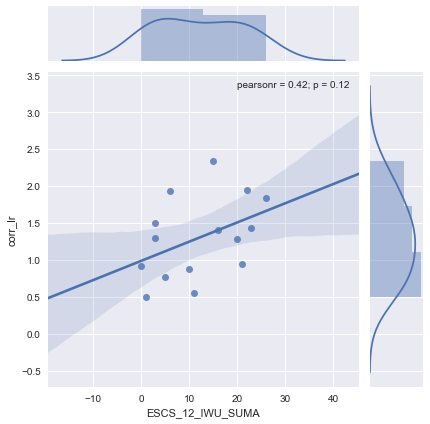

In [72]:
sns.jointplot(x="ESCS_12_IWU_SUMA", y="corr_lr", data=stats, kind="reg")

## Metody nieliniowe: analiza rekurencji

<img src="rqa_schema.png" />

In [102]:
triUL = []

os.remove("out.dat")
for name, data in df_list.items():   
    data["ROI 0"].to_csv("roi0", index=False, header=False)
    data["ROI 1"].to_csv("roi1", index=False, header=False)
    os.system("./rp_i686 -i roi0 -j roi1 -r out.tif -f TIF -o out.dat -e 0.02 -m 3 -t 25 -w 0")
    arr = misc.imread("out.tif")
    triUL.append(np.triu(arr).mean() / np.tril(arr).mean())
    
rr_data = pd.read_csv("out.dat", sep="\t")
rr_data["triUL"] = triUL
rr_data.index = [k[:-4] for k in df_list.keys()]

stats_ex = pd.concat((stats, rr_data), axis=1)

<img src="recurrence_plot.png" width="1024px" />

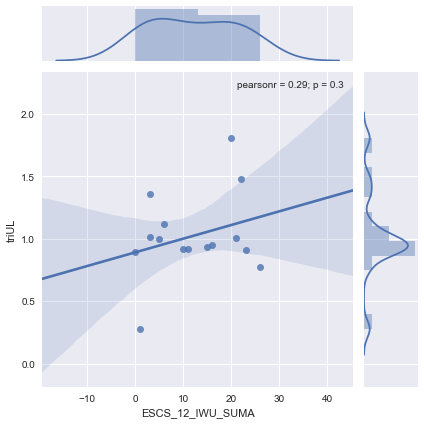

In [105]:
sns.jointplot(x="ESCS_12_IWU_SUMA", y="triUL", data=stats_ex, kind="reg")

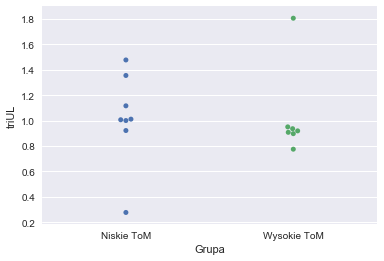

In [106]:
sns.swarmplot(y="triUL", x="Grupa", data=stats_ex)

In [108]:
ttest_ind(stats_ex["triUL"][stats_ex["Grupa"] == "Niskie ToM"], stats_ex["triUL"][stats_ex["Grupa"] == "Wysokie ToM"])

Ttest_indResult(statistic=-0.036447315975224354, pvalue=0.97147941437836771)

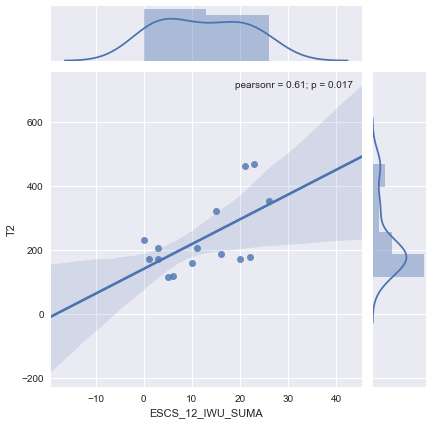

In [103]:
sns.jointplot(x="ESCS_12_IWU_SUMA", y="T2", data=stats_ex, kind="reg")

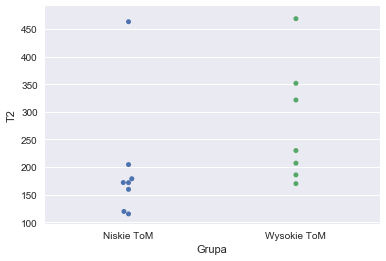

In [104]:
sns.swarmplot(y="T2", x="Grupa", data=stats_ex)

In [109]:
ttest_ind(stats_ex["T2"][stats_ex["Grupa"] == "Niskie ToM"], stats_ex["T2"][stats_ex["Grupa"] == "Wysokie ToM"])

Ttest_indResult(statistic=-1.3731865594562251, pvalue=0.19291587265816124)

## Wnioski

* Analiza synchroniczności ruchu to jedna z dróg do odkrywania znaczenia interakcji.
* Prosta różnicowa metoda poklatkowa jest wystarczająca do zmierzenia zróżnicowania synchronizacji w interakcji dziecka z rodzicem.
* Wstępne wyniki są zgodne z hipotezami o komunikacyjnym i interakcyjnym charakterze umiejętności wiązanych z teorią umysłu.
* Czy możliwe jest wytłumaczenie teorii umysłu jako umiejętności strategicznego kierowania własną i cudzą uwagą?